## 4F - Attention

Now let's compare with attention, as applied to the Chollet/Brownlee model.

### Loading our Data (Again)

In [1]:
import pickle
import os

PIK = "claim_and_title.data"

if not os.path.isfile(PIK):
    # Download file
    !wget https://benhoyle.github.io/notebooks/title_generation/claim_and_title.data

with open(PIK, "rb") as f:
    print("Loading data")
    data = pickle.load(f)
    print("{0} samples loaded".format(len(data)))
    
print("\n\nAdding start and stop tokens to output")
data = [(c, "startseq {0} stopseq".format(t)) for c, t in data]
                                      
print("\n\nAn example title:", data[0][1])
print("----")
print("An example claim:", data[0][0])

Loading data
30000 samples loaded


Adding start and stop tokens to output


An example title: startseq System and method for session restoration at geo-redundant gateways stopseq
----
An example claim: 
1. A method for managing a backup service gateway (SGW) associated with a primary SGW, the method comprising:
periodically receiving from the primary SGW at least a portion of corresponding UE session state information, the received portion of session state information being sufficient to enable the backup SGW to indicate to an inquiring management entity that UEs having an active session supported by the primary SGW are in a live state; and
in response to a failure of the primary SGW, the backup SGW assuming management of IP addresses and paths associated with said primary SGW and transmitting a Downlink Data Notification (DDN) toward a Mobility Management Entity (MME) for each of said UEs having an active session supported by the failed primary SGW to detach from the network and reat

In [2]:
from cb_model import CBModel

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
old_machine = CBModel(
    encoder_texts=[d[0] for d in data],
    decoder_texts=[d[1] for d in data],
    encoder_seq_length=300,
    decoder_seq_length=22,
    num_encoder_tokens=2500,
    num_decoder_tokens=2500,
    latent_dim=128,
    weights_file="class_oldCBModel.hdf5",
    training_set_size=250
)

Fitting tokenizers
Our input data has shape (30000, 300) and our output data has shape (30000, 22)
Generating training and test data
Loading GloVe 100d embeddings from file
Found 400000 word vectors.
Building embedding matrix
Building models for training and inference
Compiling model
No existing weights found


In [4]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

def plot_model(model):
    return Image(model_to_dot(model, show_shapes=True).create_png(prog='dot'))

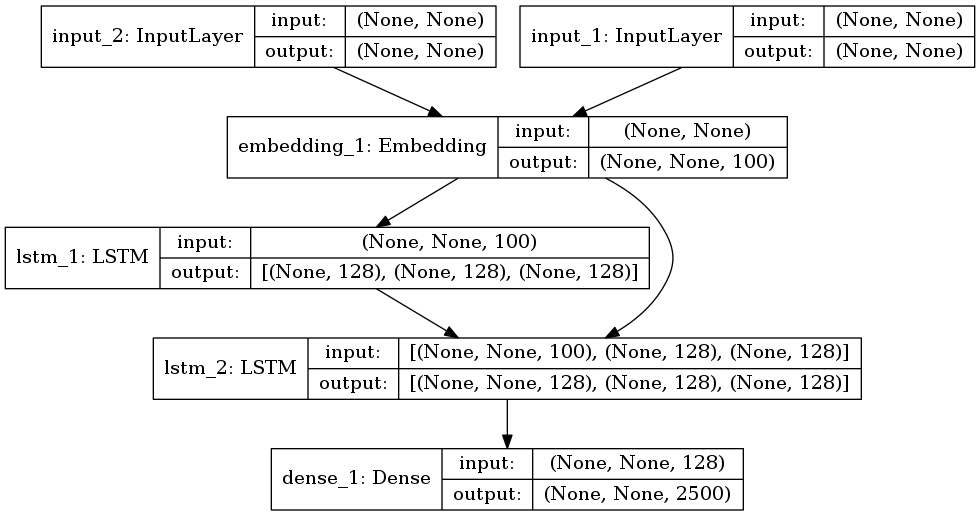

In [5]:
plot_model(old_machine.model)

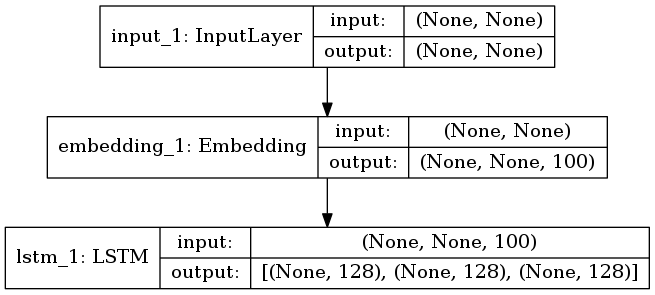

In [6]:
plot_model(old_machine.infenc)

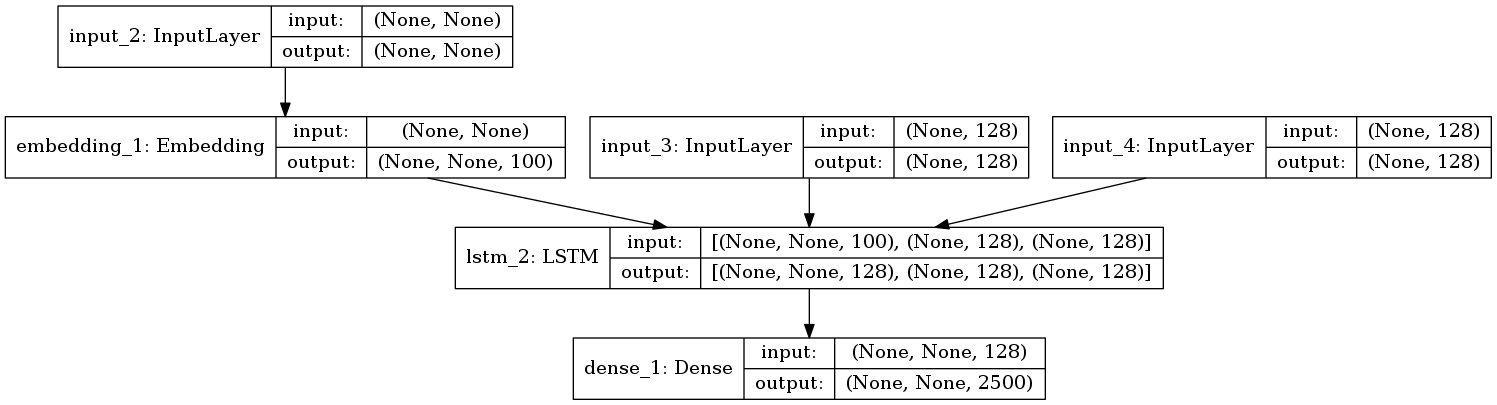

In [7]:
plot_model(old_machine.infdec)

In [8]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, concatenate, merge, Permute, \
multiply, Lambda
from keras import backend as K

class CBAtt(CBModel):
    """ Version of our Ludwig model with attention."""
    
    def _build_model(self):
        # define training encoder
        # Setup embedding layer
        print("Building models for training")
        self._load_shared_embedding()
        
        # Define inputs
        encoder_inputs = Input(shape=(self.encoder_seq_length,))
        decoder_inputs = Input(shape=(None,))
        
        shared_embedding = Embedding(
            output_dim=self.word_embedding_size,
            input_dim=self.num_encoder_tokens,
            weights=[self.embedding_matrix]
        )
        # setup encoder embedding
        encoder_embedding = shared_embedding(encoder_inputs)
        # Use LSTM states at end of sequence as encoder states
        encoder_context, state_h, state_c = \
            LSTM(self.latent_dim, return_state=True, return_sequences=True)(encoder_embedding)
        # Swap our encoded_seqs dimenions
        a = Permute((2, 1))(encoder_context)
        
        # Here we apply a dense layer to each a matrix
        a = Dense(self.encoder_seq_length, activation='softmax', use_bias=False)(a)
        # Single attention vector
        a_probs = Permute((2, 1), name='attention_vec_a')(a)
        att_mul_1 = multiply([encoder_context, a_probs])
        # Sum over time dimension
        state_h = Lambda(lambda x: K.sum(x, axis=1), name="sum_over_time_att_1")(att_mul_1)
        # Now we apply attention across the encoded_seqs to generate state_h
        encoder_states = [state_h, state_c]
        # Set up the decoder, using `encoder_states` as initial state.
        #decoder_inputs = Input(shape=(None,))
        # Use the same embedding to code the decoder input
        decoder_embedding = shared_embedding(decoder_inputs)
        # Define decoder - I think we can scrap return_state here and clear the _, _
        decoder_lstm = \
            LSTM(self.latent_dim, return_sequences=True, return_state=True)
        # Get the outputs of the decoder over all timesteps using the encoder states as the initial state
        decoder_outputs, _, _ = \
            decoder_lstm(decoder_embedding, initial_state=encoder_states)
        # We get all outputs as when we train we compare all outputs as a sequence
        # The dense layer is applied repeatedly to each of the timesteps to output predictions for all timestamps
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax')
        # This outputs sequences of token probabilities that can be compared with the one hot sequences
        decoder_outputs = decoder_dense(decoder_outputs)
        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` > `decoder_target_data`
        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
        # We use different constructions but the same weights for inference
        
        print("Building models for inference")
        # define inference encoder - this just outputs the encoder states from the inputs
        self.infenc = Model(encoder_inputs, encoder_states)
        # define inference decoder - this needs to take an input in the form
        # of hidden states and output one token probability
        decoder_state_input_h = Input(shape=(self.latent_dim,))
        decoder_state_input_c = Input(shape=(self.latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        # Need to adjust this line for the embedding
        decoder_outputs, state_h, state_c = \
            decoder_lstm(
                decoder_embedding, initial_state=decoder_states_inputs
                )
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        # The model below takes a list of [decoder_inputs, h, c] as input and outputs
        # [decoder_output, h, c] - the h, c can then be recycled for the next token
        self.infdec = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states
        )
        print("Compiling model")
        # Can we use sparse_C_C if we are using integers?
        # https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['acc']
        )
        
    

Now it is less straightforward to apply attention to this model. This is because we have separate models for training and inference. When applying attention here we just need to attend to the encoder states. In particular, we just apply attention across the `h` outputs that are returned as a sequence (not to the `c` output).

Our Inputs are originally set as shape - None as they are used with input shape 300 as well as input shape 1 (i.e. for training and inference). 

So we can apply attention during training easily but how to apply during inference when we are dealing with 1 token at a time?

Do we need to create a separate set of encoder and decoder inputs? Or could we zero pad the rest of the sequence?

In [9]:
machine = CBAtt(
    encoder_texts=[d[0] for d in data],
    decoder_texts=[d[1] for d in data],
    encoder_seq_length=300,
    decoder_seq_length=22,
    num_encoder_tokens=2500,
    num_decoder_tokens=2500,
    latent_dim=128,
    weights_file="class_CBattmodel_sin_att.hdf5",
    training_set_size=5000
)

Fitting tokenizers
Our input data has shape (30000, 300) and our output data has shape (30000, 22)
Generating training and test data
Building models for training
Loading GloVe 100d embeddings from file
Found 400000 word vectors.
Building embedding matrix
Building models for inference
Compiling model
Loaded weights


In [10]:
machine.print()

Training Model:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         multiple             250000      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 300, 128), ( 117248      embedding_2[0][0]          

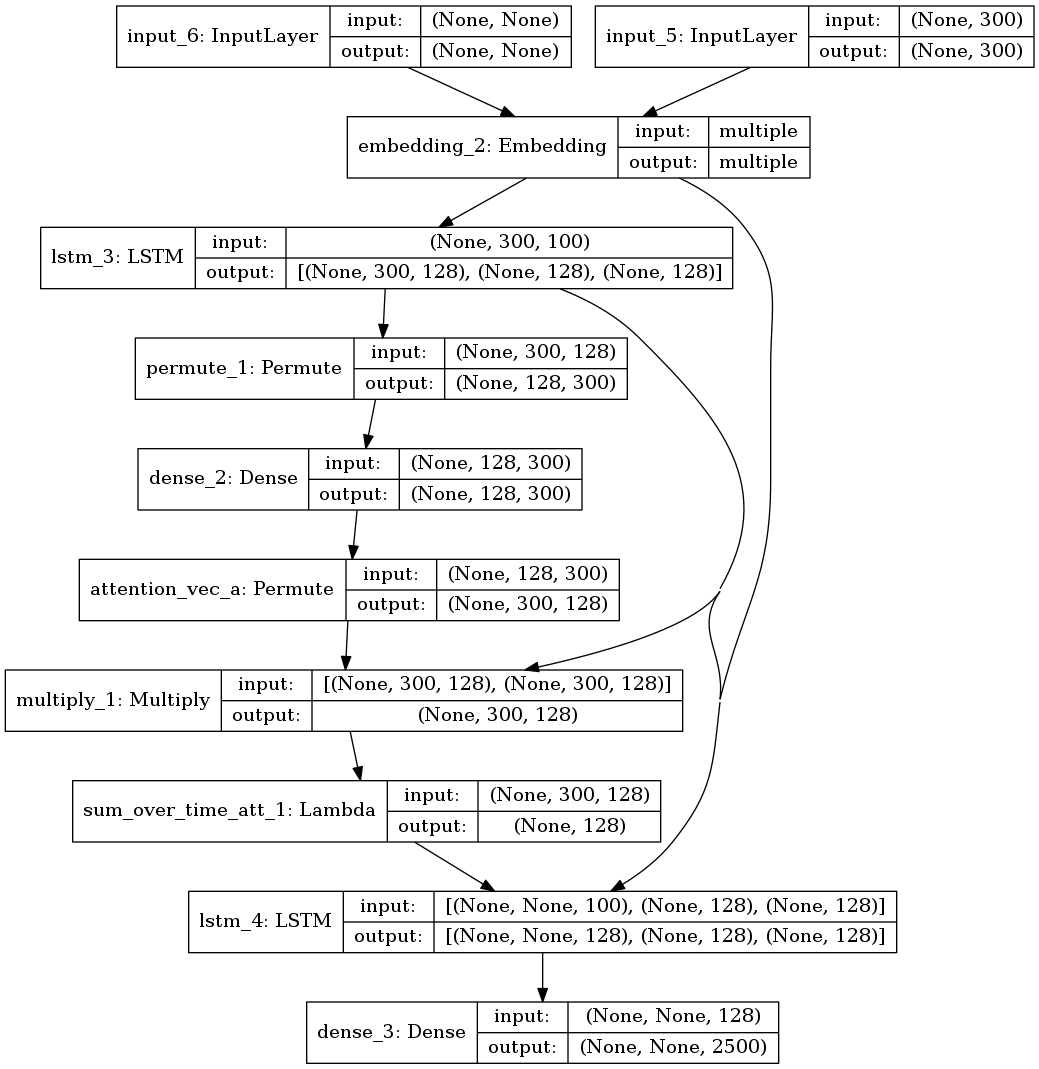

In [11]:
plot_model(machine.model)

In [12]:
machine.train(epochs=2)

Training for epoch 0
Training on batch 0 to 5000 of 24000
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 114s 23ms/step - loss: 1.9509 - acc: 0.6868 - val_loss: 1.9505 - val_acc: 0.6881
Training on batch 5000 to 10000 of 24000
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 118s 24ms/step - loss: 1.9296 - acc: 0.6900 - val_loss: 1.9273 - val_acc: 0.6859
Training on batch 10000 to 15000 of 24000
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 120s 24ms/step - loss: 1.8618 - acc: 0.6981 - val_loss: 1.8957 - val_acc: 0.6917
Training on batch 15000 to 20000 of 24000
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 118s 24ms/step - loss: 1.8529 - acc: 0.6966 - val_loss: 1.8686 - val_acc: 0.6938
Training on batch 20000 to 24000 of 24000
Train on 4000 samples, validate on 1000

ValueError: Error when checking : expected input_5 to have shape (300,) but got array with shape (1,)

This can maybe be avoided by reshaping the input to 1,1,300.

### Comments on Training



In [ ]:
import numpy as np

def sample(preds, temperature=1.0):
    """ Helper function to sample an index from a probability array. """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def _predict_from_seq(self, seq):
    """ Predict output sequence from input seq. """
    state = self.infenc.predict(seq)
    # print(state)
    target_seq = np.zeros((1, self.decoder_seq_length))
    # Add start token integer to end of ans_partial input - initially [0,0,...BOS]
    target_seq[0, -1] = self.output_dictionary["startseq"]  #  the index of the symbol BOS (begin of sentence)
    # Minus one as last entry is stopseq? But can be full length
    for k in range(self.decoder_seq_length):
        # Remember to set infdec as model when building model
        yhat, input_h, input_c = self.infdec.predict([target_seq] + state)
            
        state = [input_h, input_c]
        # update target sequence - this needs to be the argmax
        next_int = sample(yhat[0, 0, :])
        print(next_int)
        target_seq[0, 0:-1] = target_seq[0, 1:]
        target_seq[0, -1] = next_int
        # Check for stopping character
        if next_int == self.output_dictionary["stopseq"]:
            break
            
    predicted_output_seq = target_seq[0]
    return predicted_output_seq

In [ ]:
machine.input_test_data[2].shape

In [ ]:
data = machine.input_test_data[2].reshape(1,300)

In [ ]:
data

In [ ]:
_predict_from_seq(machine, data)

Using padded arrays does not work. Can we try the other way of defining a new set of inputs but using the same components and weights?

It's only the infdec that needs adjusting.